In [101]:
import pandas as pd
import numpy as np
from numpy import median
import matplotlib.pyplot as plt
import seaborn as sns

import us
from datetime import datetime, timezone

pd.set_option('display.max_columns', 999)

In [102]:
data_path = "C:/Users/armcl/Python/Springboard_Cap2/Data/" #Home
#data_path = "C:/Users/yyzhao/python/Springboard/Capstone2/Data/" #Work

In [103]:
#Read customers data
customers = pd.read_csv(data_path + "Subscription/customers.csv", encoding="utf8")

customers = customers.drop(columns = ['note','ship_street','ship_unit','location',
                                     'wrr','last4','source','customer_metadata',
                                     'ship_phone_number'])

#revenue and mrr need to be divided by 100
customers[['total_revenue','mrr']] = customers[['total_revenue','mrr']]/100


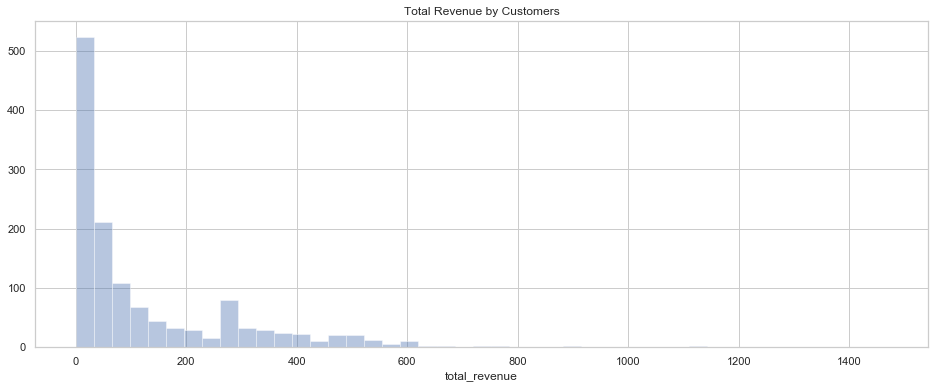

In [104]:
#Draw total_revenue by customer
#The peak at 275 is the annual subscription fee

plt.figure(figsize=(16,6))
ax = sns.distplot(customers['total_revenue'],kde=False)
ax.set_title('Total Revenue by Customers')

plt.show()

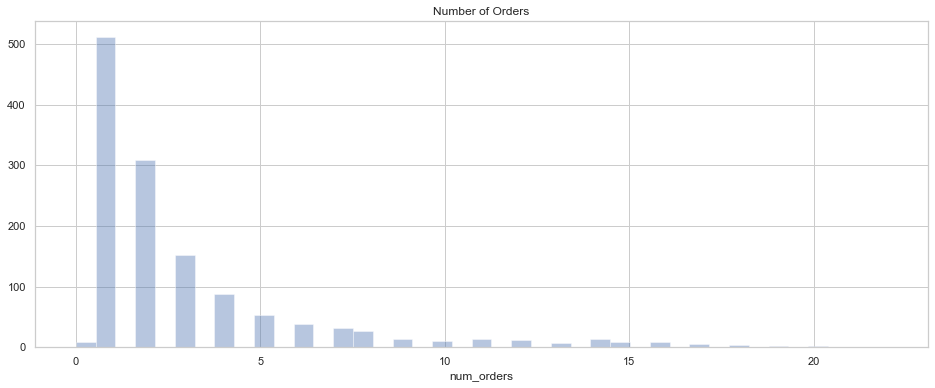

In [105]:
#Draw the number of subscriptions 
plt.figure(figsize=(16,6))
ax=sns.distplot(customers['num_orders'],kde=False)
ax.set_title('Number of Orders')
plt.show()

In [106]:
##More avg revenue from American families need to focus more on this market
family_analysis = pd.DataFrame({'count' : customers.groupby( [ 'american'] ).size()})
family_analysis['avg_revenue']=customers.groupby('american').mean()['total_revenue']
family_analysis['total_revenue']= family_analysis['count']*family_analysis['avg_revenue']
family_analysis.sort_values('total_revenue', ascending=False)
family_analysis['median_revenue'] = customers.groupby('american').median()['total_revenue']
family_analysis

,count,avg_revenue,total_revenue,median_revenue
american,,,,
0,1250,126.351360,157939.20,51.860
1,70,181.303857,12691.27,80.925


In [107]:
#Run a T-Test
#Failed to reject the null at 5% alpha. Data is small, rerun when there're more cusotomers.
from scipy import stats
#np.random.seed(88)

revenue_American = customers.loc[customers['american']==1,'total_revenue']
revenue_Chinese = customers.loc[customers['american']==0,'total_revenue']

#t, p = stats.ttest_ind(Q2_PRICE,Q4_PRICE)
t, p = stats.ttest_ind(revenue_American, revenue_Chinese, equal_var=False)
print("t = " + str(t))
print("p = " + str(p))

t = 1.9185516787640742
p = 0.05895440534485409


In [108]:
#Analyze state
#Texas shows one of the highest revenue in mean and median
state_analysis = pd.DataFrame({'count' : customers.groupby( [ 'ship_state'] ).size()})
state_analysis['avg_revenue']=customers.groupby('ship_state').mean()['total_revenue']
state_analysis['median_revenue']=customers.groupby('ship_state').median()['total_revenue']

state_analysis['total_revenue']= state_analysis['count']*state_analysis['avg_revenue']
state_analysis.sort_values('total_revenue', ascending=False).head(10)

,count,avg_revenue,median_revenue,total_revenue
ship_state,,,,
CA,503,114.867256,46.250,57778.23
WA,121,137.580826,64.900,16647.28
TX,82,180.316951,78.300,14785.99
NY,95,129.835158,57.120,12334.34
NJ,54,149.992963,60.375,8099.62
OH,34,201.547647,76.330,6852.62
PA,45,145.669111,84.850,6555.11
MA,39,161.445385,92.700,6296.37
MD,41,139.972195,19.950,5738.86


In [109]:
#Median Revenue by Subscription Status
#Mixed shows the highest total revenue and num of orders, there are many reasons:
#1) clients subscribed, cancelled(didn't like at first, on vacation), came back and subscribed again
#2) accidentally ordered more than needed and cancelled
#3) clients ordered gifts for friends and cancelled/expired later
#4) currently cancelled and there were expired gifts
#5) clients tried several ages first and decided to keep one that fits child's age

#It's hard to interpret with all these different factors
#Need to combine with subscription and cancellation reason data for better information
#For example: cancelled+active vs. cancelled+expired
#customers.groupby('subscription_status').mean()

In [110]:
#Subscription Data

#Use email to merge
#Fullfillment status == 'cancelled': this probably means 
#1)when total_revenue = 0: accidental orders
#2)when total_revenue is not 0 and refunded mad customers

#Date, need to convert to local time for timing analysis, default is PDT
#Questions like1) what time do peoplel like to subscribe/cancel 2)when do they like to open emails and take actions

subscriptions = pd.read_csv(data_path + "Subscription/subscriptions.csv", encoding="utf8")

#Drop columns with all NAs
subscriptions = subscriptions.dropna(axis=1, how='all')

#revenue to numeric
subscriptions['Total Revenue'] = subscriptions['Total Revenue'].replace('[\$,]', '', regex=True).astype(float)

#subscriptions.head(2)

In [111]:
#Merge several columns

subscriptions['Subscription_Product'] = subscriptions[['Subscription Product 1','Subscription Product 2','Subscription Product 3',
               'Subscription Product 4','Subscription Product 5']].apply(lambda x: x.str.cat(sep=''), axis=1)

#Product name changed but essentially the same
subscriptions['Subscription_Product'] = subscriptions['Subscription_Product'].replace({'0-2岁熊猫金袋':'0-2 box',
                                                                                     '0-2岁熊猫盒子':'0-2 box',
                                                                                       '2-5岁熊猫金袋':'2-5 box',
                                                                                     '2-5岁熊猫盒子':'2-5 box',
                                                                                       '5岁+熊猫金袋':'5+ box',
                                                                                     '5岁+熊猫盒子':'5+ box'})

subscriptions['Child_Age'] = subscriptions[[' Subscription Product 1 Survey Field: 宝宝现在几岁了？* ',' Subscription Product 2 Survey Field: 宝宝现在几岁了？* ',' Subscription Product 3 Survey Field: 宝宝现在几岁了？* ',
               ' Subscription Product 4 Survey Field: 宝宝现在几岁了？* ',' Subscription Product 5 Survey Field: 宝宝现在几岁了？* ']].apply(lambda x: x.dropna().astype(str).str.cat(sep=''), axis=1)

subscriptions['Child_Age'] = pd.to_numeric(subscriptions['Child_Age'], errors='coerce')

#age 0 is showing as NA, change them to 0 again
subscriptions['Child_Age'].fillna(0, inplace=True)

subscriptions['Child_Gender'] = subscriptions[['Subscription Product 1 Survey Field: 男娃女娃？*','Subscription Product 2 Survey Field: 男娃女娃？*','Subscription Product 3 Survey Field: 男娃女娃？*',
               'Subscription Product 4 Survey Field: 男娃女娃？*','Subscription Product 5 Survey Field: 男娃女娃？*']].apply(lambda x: x.str.cat(sep=''), axis=1)

subscriptions['Child_Gender'] = subscriptions['Child_Gender'].replace('Girl 女孩','Girl')
subscriptions['Child_Gender'] = subscriptions['Child_Gender'].replace('Boy 男孩','Boy')

subscriptions['Coupon_Used_List'] = subscriptions[['Active Coupon 1','Inactive Coupon 1','Inactive Coupon 2',
               'Inactive Coupon 3']].apply(lambda x: x.str.cat(sep=','), axis=1)

#Create a new variable: if coupon used or not
subscriptions['Coupon_Used'] = 'Used_Coupon'
subscriptions.loc[subscriptions['Coupon_Used_List']=='','Coupon_Used'] = 'Not_Used_Coupon'

subscriptions['Is a Gift'] = subscriptions['Is a Gift'].replace({True:'Gift',False:'Not_Gift'})


subscriptions = subscriptions[subscriptions.columns[~subscriptions.columns.str.contains('Survey')]]
subscriptions = subscriptions[subscriptions.columns[~subscriptions.columns.str.contains('Subscription Product')]]
subscriptions = subscriptions[subscriptions.columns[~subscriptions.columns.str.contains('Inactive Coupon')]]
subscriptions = subscriptions[subscriptions.columns[~subscriptions.columns.str.contains('Active Coupon 1')]]
subscriptions = subscriptions[subscriptions.columns[~subscriptions.columns.str.contains('Billing')]]
subscriptions = subscriptions[subscriptions.columns[~subscriptions.columns.str.contains('Recipient')]]


In [112]:
#Deal with time

subscriptions['Start_Date_dt']= pd.to_datetime(subscriptions['Start Date']+'/'+subscriptions['Start Date Time'])
subscriptions['End_Date_dt']= pd.to_datetime(subscriptions['End Date']) 
subscriptions['Cancel_Date_dt']= pd.to_datetime(subscriptions['Last Cancel Date']+'/'+subscriptions['Last Cancel Date Time'].astype(str).str[:-5])
subscriptions['Cancel_Date_dt'].fillna('', inplace=True)

#Convert to local time based on country and state
#Create Time Zones
subscriptions['Time_Zone'] = subscriptions.apply(
    lambda row : us.states.lookup(row['Shipping Province']).capital_tz if ((row['Shipping Country']=='US') & (row['Shipping Province']!='AE')) else "", axis = 1) 

subscriptions.loc[(subscriptions['Shipping Country']=='US') 
                  & (subscriptions['Shipping Province']=='AE'),'Time_Zone'] = 'America/Los_Angeles'

subscriptions.loc[(subscriptions['Shipping Country']=='CA') 
                  & (subscriptions['Shipping Province']=='AB'),'Time_Zone'] = 'America/Denver'

subscriptions.loc[(subscriptions['Shipping Country']=='CA') 
                  & (subscriptions['Shipping Province']=='ON'),'Time_Zone'] = 'America/New_York'

subscriptions.loc[subscriptions['Shipping Country']=='MY','Time_Zone'] = 'Asia/Kuala_Lumpur'

subscriptions['Start_Date_Long'] = subscriptions.apply(lambda row : row['Start_Date_dt'].tz_localize('America/Los_Angeles').tz_convert(row['Time_Zone']), axis = 1)

subscriptions['Cancel_Date_Long'] = subscriptions.apply(lambda row : row['Cancel_Date_dt'].tz_localize('America/Los_Angeles').tz_convert(row['Time_Zone']) if row['Cancel_Date_dt']!='' else "", axis = 1)

In [113]:
#Create new features

#Window from subscription to cancellation
subscriptions.loc[subscriptions['Cancel_Date_Long']!='','canceled_tenure'] = subscriptions.loc[subscriptions['Cancel_Date_Long']!='','Cancel_Date_Long'] - subscriptions.loc[subscriptions['Cancel_Date_Long']!='','Start_Date_Long']
subscriptions['canceled_tenure'] = subscriptions.apply(lambda row: row['canceled_tenure'].days,axis=1)

#Tenue for active subscribers
subscriptions.loc[subscriptions['Cancel_Date_Long']=='','active_tenure'] = datetime.now() - pd.to_datetime(subscriptions['Start Date'])
subscriptions['active_tenure'] = subscriptions.apply(lambda row: row['active_tenure'].days,axis=1)

#subscribed/cancelled date and time
subscriptions['subscribe_date'] = subscriptions.apply(lambda row: row['Start_Date_Long'].day if row['Start_Date_Long']!='' else '',axis=1)
subscriptions['subscribe_hour'] = subscriptions.apply(lambda row: row['Start_Date_Long'].hour if row['Start_Date_Long']!='' else '',axis=1)
subscriptions['cancel_date'] = subscriptions.apply(lambda row: row['Cancel_Date_Long'].day if row['Cancel_Date_Long']!='' else '',axis=1)
subscriptions['cancel_hour'] = subscriptions.apply(lambda row: row['Cancel_Date_Long'].hour if row['Cancel_Date_Long']!='' else '',axis=1)


In [114]:
#Merge subscriptions with customer data to get the ethnics
subscriptions = pd.merge(subscriptions, customers[['email','american','payment_provider']], left_on = 'Email', right_on='email', how='left')

In [115]:
#Create dummy variables
subscriptions = pd.concat([subscriptions, subscriptions['Subscription_Product'].str.get_dummies(sep=',')], axis=1)
subscriptions = pd.concat([subscriptions, subscriptions['Term'].str.get_dummies(sep=',')], axis=1)
subscriptions = pd.concat([subscriptions, subscriptions['Status'].str.get_dummies(sep=',')], axis=1)
subscriptions = pd.concat([subscriptions, subscriptions['Coupon_Used'].str.get_dummies(sep=',')], axis=1)
subscriptions = pd.concat([subscriptions, subscriptions['Is a Gift'].str.get_dummies(sep=',')], axis=1)
#subscriptions = pd.concat([subscriptions, subscriptions['Source'].str.get_dummies(sep=',')], axis=1)
subscriptions = pd.concat([subscriptions, subscriptions['Child_Gender'].str.get_dummies(sep=',')], axis=1)
subscriptions = pd.concat([subscriptions, subscriptions['Coupon_Used_List'].str.get_dummies(sep=',')], axis=1)
subscriptions = pd.concat([subscriptions, subscriptions['payment_provider'].str.get_dummies(sep=',')], axis=1)

#Create a new variable number of coupons used
subscriptions['Num_Coupons_Used'] = subscriptions.loc[:,'1STPANDA10OFF':'ZYLYZXY'].sum(axis=1)

#Remove features not relevant
subscriptions = subscriptions.drop(columns=['Start Date','Start Date Time','End Date',
                                           'Last Cancel Date','Last Cancel Date Time',
                                           'Source','Shipping Address 1',
                                           'Shipping Address 2','Time_Zone','email','payment_provider',
                                           'Coupon_Used_List'])

#If fullfillment status = cancelled AND revenue = 0 
#Then these are accidentally placed duplicate orders, and cancelled by the merchant need to remove from the data

subscriptions = subscriptions.drop(subscriptions[(subscriptions['Fulfillment Status'] == 'CANCELLED') & (subscriptions['Total Revenue'] == 0)].index)

#Also, remove VIP FREE subscriptions 
subscriptions = subscriptions.loc[subscriptions['DIYA']!=1,:]
subscriptions = subscriptions.loc[subscriptions['USMAMAVIP']!=1,:]
subscriptions = subscriptions.loc[subscriptions['MESSYCOWVIP']!=1,:]

#Also, need to remove month to month subscription plans which was upgraded to annual plan (feature: "upgrade")

subscriptions['upgrade'] = 0

for index, row in subscriptions.iterrows():
    
    if (row['Status'] == 'cancelled' and row['Term'] == 'Month to Month'):
        Email = row['Email']
        Age = row['Subscription_Product']
        End_Date = row['Cancel_Date_dt']
        Start_Date = subscriptions.loc[(subscriptions['Email'] == Email) & (subscriptions['Term'] == '12 Month Prepay')
                                       & (subscriptions['Subscription_Product'] == Age), 'Start_Date_dt']
        #print(abs(pd.to_datetime(Start_Date.values) - pd.to_datetime(End_Date)).days.values <=3)
        if abs(pd.to_datetime(Start_Date.values) - pd.to_datetime(End_Date)).days.values <=3:
            subscriptions.loc[(subscriptions['Email'] == Email) & (subscriptions['Term'] == 'Month to Month'), 'upgrade'] = 1

subscriptions = subscriptions[subscriptions['upgrade']==0]

#Also, need to remove expired gift since those are more like one-time order
#for the rest of expired, they are customers who subscribed with auto-renewaing but at some
#point of time their cc expired and they didn't want to update the cc after notifications
#that suggests they want to cancel, so relabel them as canceled

#Find the people whose status is expired but was in auto-renewing
subscriptions.loc[(subscriptions['expired']==1)&(subscriptions['Auto-Renewing Subscription']==True),'cancelled']=1
subscriptions.loc[(subscriptions['expired']==1)&(subscriptions['Auto-Renewing Subscription']==True),'expired']=0

#Remove the other expired
subscriptions = subscriptions.loc[subscriptions['expired']!=1,:]

C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [116]:
#Get the average life span for month to month plan subscribers and the churn rate

#Combine tenure into one column; in days
subscriptions['life_span'] = subscriptions['canceled_tenure'].fillna(subscriptions['active_tenure'])

lifespan_m2m = subscriptions.loc[subscriptions['Term']=='Month to Month','life_span']/30
print('Average lifespan for month to month plan is: ', lifespan_m2m.mean())

Average lifespan for month to month plan is:  3.0681755829903965


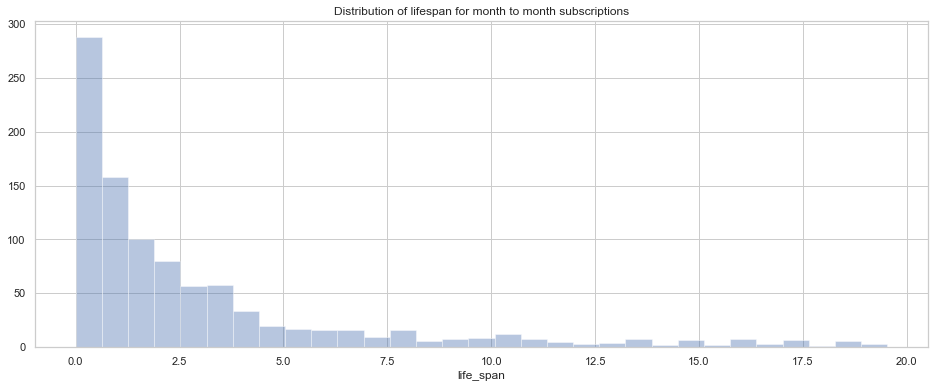

In [117]:
#Some of them actually upgraded to annual plan
plt.figure(figsize=(16, 6))
ax = sns.distplot(lifespan_m2m, kde=False)
ax.set_title("Distribution of lifespan for month to month subscriptions")

plt.show()

In [118]:
#Cancellation is more likely at round 17th which is the renewal date
#People are more likely to subscribe 1 week before the subscription cutoff date probably due to promotions

date_analysis = subscriptions.groupby('cancel_date').size().to_frame(name = 'count').reset_index().iloc[:-1]
date_analysis.rename(columns={'cancel_date':'Date','count':'cancel_date'}, inplace = True)
date_analysis['subscribe_date'] = subscriptions.groupby('subscribe_date').size().to_frame(name = 'count').reset_index()['count']
date_analysis

,Date,cancel_date,subscribe_date
0,1,26,76
1,2,10,44
2,3,14,54
3,4,14,40
4,5,20,69
5,6,26,48
6,7,34,111
7,8,34,26
8,9,31,43
9,10,39,36


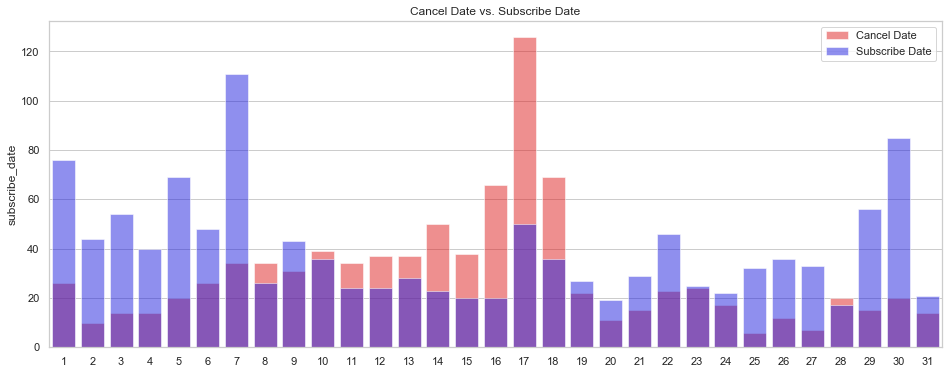

In [119]:
#Add a hist chart
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="Date", y="cancel_date", data=date_analysis, color='red',label='Cancel Date',alpha=0.5,ci=None)
ax = sns.barplot(x="Date", y="subscribe_date", data=date_analysis, color='blue',label='Subscribe Date',alpha=0.5,ci=None)

ax.set_title("Cancel Date vs. Subscribe Date")
ax.set_xlabel('')
ax.legend()
plt.show()

In [120]:
#People are more likely to cancel at nights
#But subscribe happen at night and in the afternoon: maybe send emails just before they have time to subscribe
#Or, it might be caused by the campaign send out time which is usually in the morning

hour_analysis = pd.merge(subscriptions.groupby('cancel_hour').size().to_frame(name ='cancel_hour'), subscriptions.groupby('subscribe_hour').size().to_frame(name ='subscribe_hour'), left_index=True, right_index=True, how='outer').reset_index().iloc[:-1].fillna(0)
hour_analysis.rename(columns={'index':'Hour'}, inplace = True)
hour_analysis

,Hour,cancel_hour,subscribe_hour
0,0,34.0,37.0
1,1,17.0,15.0
2,2,10.0,7.0
3,3,2.0,2.0
4,4,0.0,1.0
5,5,5.0,0.0
6,6,13.0,11.0
7,7,17.0,10.0
8,8,37.0,27.0
9,9,56.0,50.0


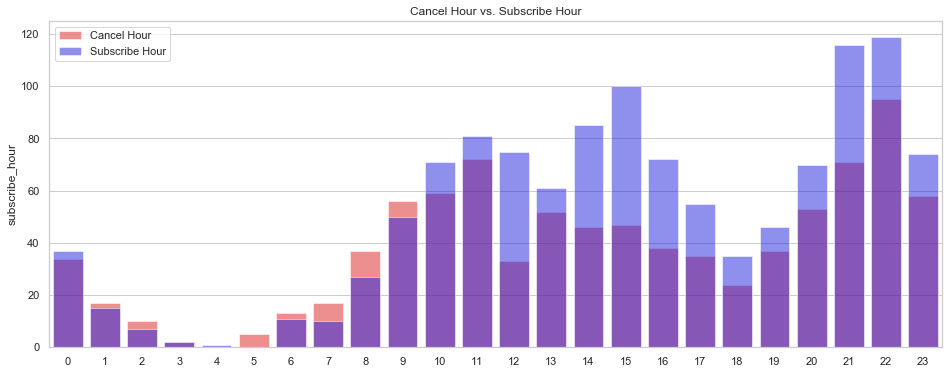

In [121]:
#Add a hist chart
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="Hour", y="cancel_hour", data=hour_analysis, color='red',label='Cancel Hour',alpha=0.5,ci=None)
ax = sns.barplot(x="Hour", y="subscribe_hour", data=hour_analysis, color='blue',label='Subscribe Hour',alpha=0.5,ci=None)

ax.set_title("Cancel Hour vs. Subscribe Hour")
ax.set_xlabel('')
ax.legend()
plt.show()

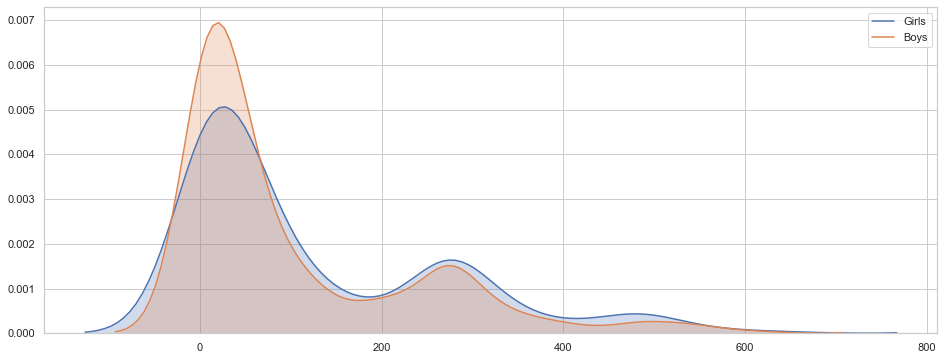

In [122]:
#Hypothesis: girls are earlier to develop language skills and like books than boys and thus more revenues from this group

subscriptions_girls = subscriptions.loc[subscriptions['Child_Gender']=='Girl',:] 
subscriptions_boys = subscriptions.loc[subscriptions['Child_Gender']=='Boy',:] 

plt.figure(figsize=(16, 6))
ax = sns.kdeplot(subscriptions_girls['Total Revenue'], shade = True, label="Girls")
ax = sns.kdeplot(subscriptions_boys['Total Revenue'], shade = True, label="Boys")

plt.legend()
plt.show()

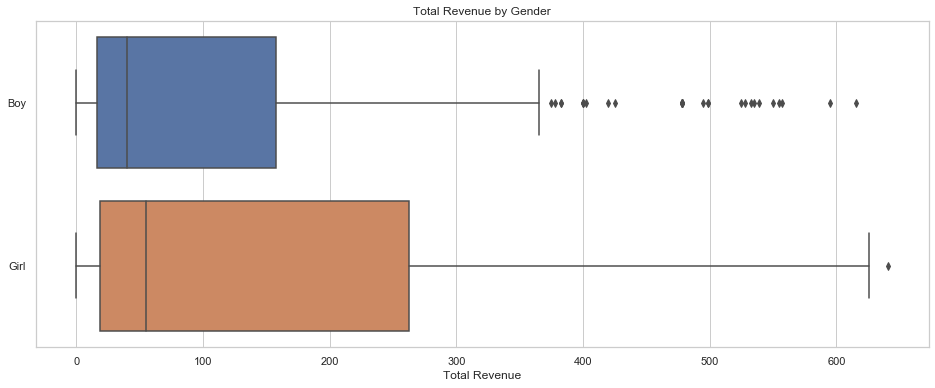

In [123]:
#Revenue by gender
#mean, median and all percentiles are higher for girls but it also have a higher stdev

plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="Total Revenue", y="Child_Gender", orient="h", data=subscriptions)
#ax = sns.swarmplot(x="PRICE", y="CITY", orient="h", data=redfin, color="white")
ax.set_title("Total Revenue by Gender")
ax.set_ylabel('')

plt.show()

In [124]:
#Run a T Test
#Null: the means are the same for girls and boys
#Null is rejected
#This is assuming holding all other variables constant
#A multivariate regression will be more rigorous in controlling other features

from scipy import stats
#np.random.seed(88)

revenue_girls = subscriptions_girls['Total Revenue']
revenue_boys = subscriptions_boys['Total Revenue']

#t, p = stats.ttest_ind(Q2_PRICE,Q4_PRICE)
t, p = stats.ttest_ind(revenue_girls, revenue_boys, equal_var=False)
print("t = " + str(t))
print("p = " + str(p))

t = 2.6483471968048686
p = 0.008193390045410844


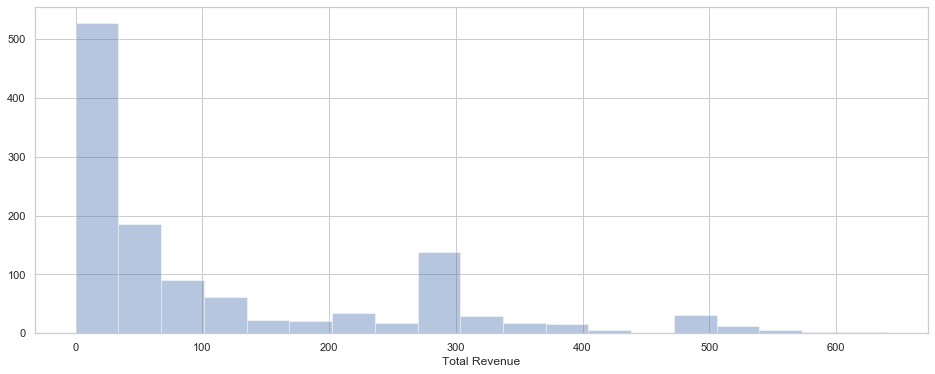

In [125]:
#Plot the distribution of total revenue
#Long tail on the right
#The peak at 275 is the cost of 1 year subscription

plt.figure(figsize=(16, 6))
ax = sns.distplot(subscriptions['Total Revenue'], kde=False)
plt.show()

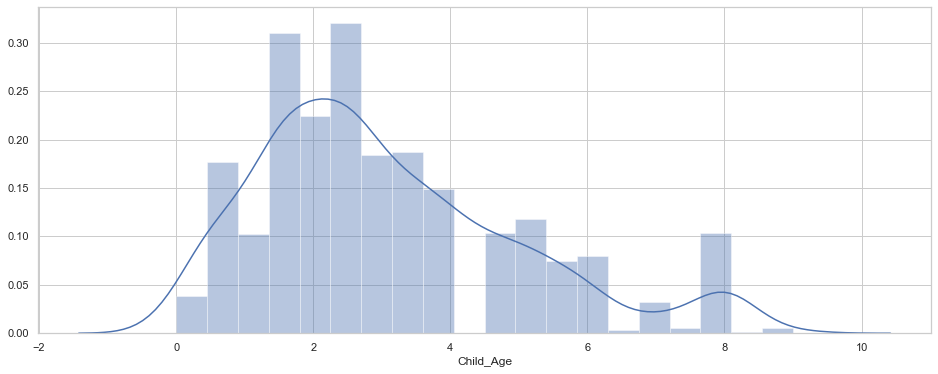

In [126]:
#Plot the distribution of child age
#Long tail on the right
plt.figure(figsize=(16, 6))
ax = sns.distplot(subscriptions['Child_Age'])
plt.show()

In [127]:
subscriptions.groupby('Status').mean()

,Subscription ID,Total Revenue,Auto-Renewing Subscription,Initial Order ID,Child_Age,canceled_tenure,active_tenure,subscribe_date,subscribe_hour,american,0-2 box,2-5 box,5+ box,12 Month Prepay,Month to Month,active,cancelled,expired,Not_Used_Coupon,Used_Coupon,Gift,Not_Gift,Boy,Girl,1STPANDA10OFF,DDDHHHZZZ,DIYA,ERXIGUO,GALA,GALTOGETHER10OFF,GALTOGETHER10OFF3M,GT1STFREE,GTFRESH,GTLOVE,GTLUCKY,GTMOM,GTNIAN,GTPANDA3M,GTSPRING,GTXMAS,GXFXXMHZ,HAPPY100DAYS,HEYWOW,HOTPANDA,KKMANDARIN,LIHANPANDA,LIHANSBOOKNEST,LINGOBUS,LOVECX,LUCKYMAMA,LUCKYMOM,LUCKYPANDA,LUCKYU,MDYANG,MESSYCOW,MESSYCOWVIP,MOLO,NIUMAVIP,PANDA09,PANDA10,PANDA127,PANDA1STFREE,PANDA54,PANDABUNNY,PANDACJ,PANDALOVE,PANDAMOM,PANDAMYDEAR,PANDAPICKUP,PANDAREUNION,PANDASHOP10,PANDASPRING,PANDAYAO,PANDAYEAR,RF2GET1FREE,RF3GET1FREE,RF6GET2NDFREE,SHIP50,SPONGELAB,USMAMA,USMAMA1Y,USMAMAVIP,USMAMAZJ,VIPFIRSTFREE,VIPFREEINF,VIPINFLUENCER,WEEE,WEEEVIP,XM,XMBABA,XMJSLH,XMPANDA,XMSEA,XMTTCD,XMVIP,XMXQ,XPANDA,XQDW,XQDWPD,YWZGG,ZYLYZXY,PAYPAL,STRIPE,Num_Coupons_Used,upgrade,life_span
Status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
active,2.195282e+09,281.873883,0.983819,2.195277e+09,3.037961,NaN,323.569579,15.333333,14.928803,0.061489,0.213592,0.666667,0.119741,0.653722,0.346278,1.0,0.0,0.0,0.514563,0.485437,0.029126,0.970874,0.404531,0.595469,0.012945,0.009709,0.0,0.006472,0.000000,0.000000,0.009709,0.000000,0.000000,0.000000,0.003236,0.000000,0.006472,0.003236,0.000000,0.016181,0.000000,0.000000,0.003236,0.016181,0.000000,0.000000,0.000000,0.000000,0.009709,0.000000,0.003236,0.022654,0.000000,0.003236,0.006472,0.0,0.009709,0.012945,0.042071,0.000000,0.003236,0.003236,0.000000,0.009709,0.003236,0.006472,0.000000,0.003236,0.003236,0.029126,0.003236,0.009709,0.003236,0.003236,0.003236,0.012945,0.000000,0.000000,0.000000,0.058252,0.012945,0.0,0.000000,0.006472,0.000000,0.0,0.000000,0.003236,0.000000,0.003236,0.003236,0.042071,0.000000,0.000000,0.093851,0.003236,0.012945,0.003236,0.000000,0.003236,0.000000,0.268608,0.724919,0.540453,0.0,323.569579
cancelled,2.008525e+09,55.287461,0.998881,2.008524e+09,3.101510,78.201342,NaN,14.248322,15.343400,0.050336,0.361298,0.494407,0.144295,0.049217,0.950783,0.0,1.0,0.0,0.130872,0.869128,0.003356,0.996644,0.519016,0.480984,0.008949,0.008949,0.0,0.011186,0.001119,0.002237,0.005593,0.012304,0.002237,0.003356,0.005593,0.003356,0.000000,0.000000,0.003356,0.015660,0.001119,0.001119,0.002237,0.146532,0.002237,0.002237,0.001119,0.006711,0.004474,0.010067,0.001119,0.213647,0.004474,0.000000,0.002237,0.0,0.002237,0.000000,0.097315,0.002237,0.014541,0.002237,0.001119,0.008949,0.012304,0.004474,0.002237,0.000000,0.011186,0.516779,0.000000,0.003356,0.003356,0.000000,0.000000,0.020134,0.001119,0.004474,0.001119,0.030201,0.000000,0.0,0.004474,0.020134,0.001119,0.0,0.002237,0.000000,0.001119,0.003356,0.001119,0.016779,0.001119,0.003356,0.005593,0.001119,0.015660,0.003356,0.004474,0.001119,0.003356,0.267338,0.610738,1.312081,0.0,78.201342
expired,1.936443e+09,97.647059,1.000000,1.936443e+09,3.504706,161.117647,NaN,16.235294,14.235294,0.058824,0.235294,0.647059,0.117647,0.117647,0.882353,0.0,1.0,0.0,0.411765,0.588235,0.000000,1.000000,0.470588,0.529412,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.235294,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.176471,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.470588,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.176471,0.823529,1.000000,0.0,161.117647


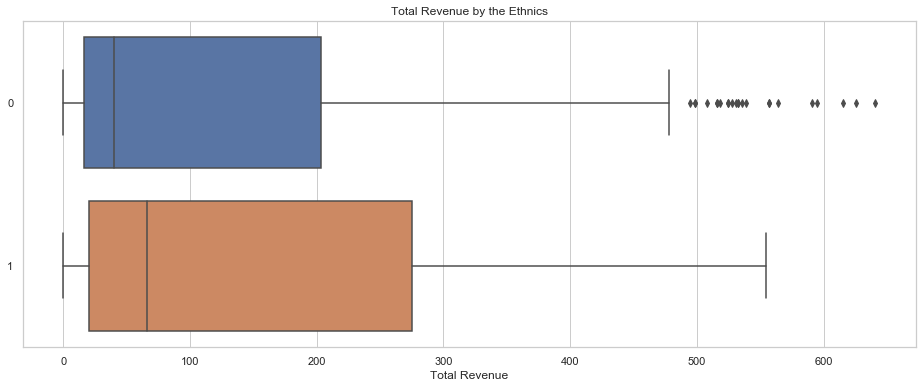

In [128]:
#American families tend to spend more
plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="Total Revenue", y="american", orient="h", data=subscriptions)
#ax = sns.swarmplot(x="PRICE", y="CITY", orient="h", data=redfin, color="white")
ax.set_title("Total Revenue by the Ethnics")
ax.set_ylabel('')

plt.show()

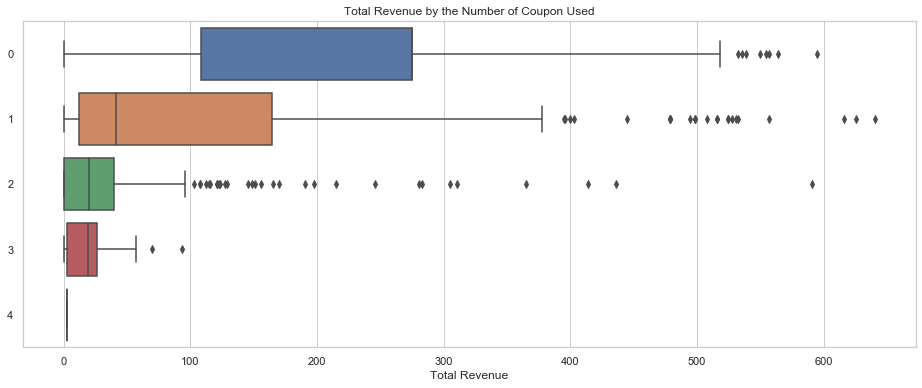

In [129]:
#Revenue by coupon used
#WOW, this is interesting! More coupons used -> less revenue from the customers (obviously but not so obvoiusly)
plt.figure(figsize=(16, 6))
ax = sns.boxplot(x="Total Revenue", y="Num_Coupons_Used", orient="h", data=subscriptions)
#ax = sns.swarmplot(x="PRICE", y="CITY", orient="h", data=redfin, color="white")
ax.set_title("Total Revenue by the Number of Coupon Used")
ax.set_ylabel('')

plt.show()

In [130]:
subscriptions.describe()

,Subscription ID,Total Revenue,Initial Order ID,Child_Age,canceled_tenure,active_tenure,subscribe_date,subscribe_hour,american,0-2 box,2-5 box,5+ box,12 Month Prepay,Month to Month,active,cancelled,expired,Not_Used_Coupon,Used_Coupon,Gift,Not_Gift,Boy,Girl,1STPANDA10OFF,DDDHHHZZZ,DIYA,ERXIGUO,GALA,GALTOGETHER10OFF,GALTOGETHER10OFF3M,GT1STFREE,GTFRESH,GTLOVE,GTLUCKY,GTMOM,GTNIAN,GTPANDA3M,GTSPRING,GTXMAS,GXFXXMHZ,HAPPY100DAYS,HEYWOW,HOTPANDA,KKMANDARIN,LIHANPANDA,LIHANSBOOKNEST,LINGOBUS,LOVECX,LUCKYMAMA,LUCKYMOM,LUCKYPANDA,LUCKYU,MDYANG,MESSYCOW,MESSYCOWVIP,MOLO,NIUMAVIP,PANDA09,PANDA10,PANDA127,PANDA1STFREE,PANDA54,PANDABUNNY,PANDACJ,PANDALOVE,PANDAMOM,PANDAMYDEAR,PANDAPICKUP,PANDAREUNION,PANDASHOP10,PANDASPRING,PANDAYAO,PANDAYEAR,RF2GET1FREE,RF3GET1FREE,RF6GET2NDFREE,SHIP50,SPONGELAB,USMAMA,USMAMA1Y,USMAMAVIP,USMAMAZJ,VIPFIRSTFREE,VIPFREEINF,VIPINFLUENCER,WEEE,WEEEVIP,XM,XMBABA,XMJSLH,XMPANDA,XMSEA,XMTTCD,XMVIP,XMXQ,XPANDA,XQDW,XQDWPD,YWZGG,ZYLYZXY,PAYPAL,STRIPE,Num_Coupons_Used,upgrade,life_span
count,1.220000e+03,1220.000000,1.220000e+03,1220.000000,911.000000,309.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.0,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.0,1220.000000,1220.00000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.00000,1220.000000,1220.000000,1220.00000,1220.00000,1220.000000,1220.000000,1220.000000,1220.000000,1220.00000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.00000,1220.000000,1220.0,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.00000,1220.000000,1220.000000,1220.000000,1220.000000,1220.00000,1220.000000,1220.000000,1220.00000,1220.000000,1220.000000,1220.00000,1220.00000,1220.000000,1220.00000,1220.000000,1220.00000,1220.000000,1220.000000,1220.0,1220.000000,1220.000000,1220.00000,1220.0,1220.000000,1220.00000,1220.00000,1220.000000,1220.000000,1220.000000,1220.00000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.000000,1220.0,1220.000000
mean,2.054822e+09,113.267230,2.054820e+09,3.091033,79.748628,323.569579,14.550820,15.222951,0.053279,0.322131,0.540164,0.137705,0.203279,0.796721,0.253279,0.746721,0.0,0.231967,0.768033,0.009836,0.990164,0.489344,0.510656,0.009836,0.009016,0.0,0.009836,0.00082,0.001639,0.006557,0.009016,0.001639,0.002459,0.004918,0.002459,0.001639,0.00082,0.002459,0.015574,0.00082,0.00082,0.002459,0.111475,0.001639,0.001639,0.00082,0.005738,0.005738,0.007377,0.001639,0.165574,0.003279,0.00082,0.003279,0.0,0.004098,0.003279,0.084426,0.001639,0.011475,0.002459,0.00082,0.009016,0.010656,0.004918,0.001639,0.00082,0.009016,0.392623,0.00082,0.004918,0.003279,0.00082,0.00082,0.018033,0.00082,0.003279,0.00082,0.036885,0.003279,0.0,0.003279,0.016393,0.00082,0.0,0.001639,0.00082,0.00082,0.003279,0.001639,0.022951,0.00082,0.002459,0.027869,0.001639,0.014754,0.003279,0.003279,0.001639,0.002459,0.266393,0.642623,1.112295,0.0,141.503279
std,2.723313e+08,138.666189,2.723294e+08,1.939715,99.864278,167.173075,9.748261,5.682418,0.224681,0.467485,0.498589,0.344731,0.402603,0.402603,0.435068,0.435068,0.0,0.422261,0.422261,0.098728,0.098728,0.500091,0.500091,0.098728,0.094564,0.0,0.098728,0.02863,0.040472,0.080745,0.094564,0.040472,0.049548,0.069985,0.049548,0.040472,0.02863,0.049548,0.123870,0.02863,0.02863,0.049548,0.314849,0.040472,0.040472,0.02863,0.075561,0.075561,0.085607,0.040472,0.371850,0.057189,0.02863,0.057189,0.0,0.063913,0.057189,0.278140,0.040472,0.106551,0.049548,0.02863,0.094564,0.102717,0.069985,0.040472,0.02863,0.094564,0.488534,0.02863,0.069985,0.057189,0.02863,0.02863,0.133124,0.02863,0.057189,0.02863,0.188557,0.057189,0.0,0.057189,0.127035,0.02863,0.0,0.040472,0.02863,0.02863,0.057189,0.040472,0.149808,0.02863,0.049548,0.164665,0.040472,0.120616,0.057189,

In [131]:
#Group by subscription status
#some expired are due to CC expired (a nice way to cancel :()
subscriptions.groupby('Status').size()

Status
active       309
cancelled    894
expired       17
dtype: int64

In [132]:
#Cancellation Data
cancellations = pd.read_csv(data_path + "Subscription/cancellations.csv", encoding="utf8")

In [133]:
cancel_reason_count = cancellations.groupby('cancel_reason').size().sort_values(ascending=False)

cancel_reason_count/cancel_reason_count.sum()

cancel_reason
resubscribe_later       0.292233
test_it_out             0.182524
other                   0.180583
did_not_like_product    0.071845
gift                    0.061165
prevent_renewal         0.046602
not_worth_price         0.041748
accidental_order        0.039806
trying_other_service    0.033010
merchant_cancelled      0.021359
other_service_issue     0.015534
shipping_issues         0.011650
fraud                   0.000971
billed_twice            0.000971
dtype: float64

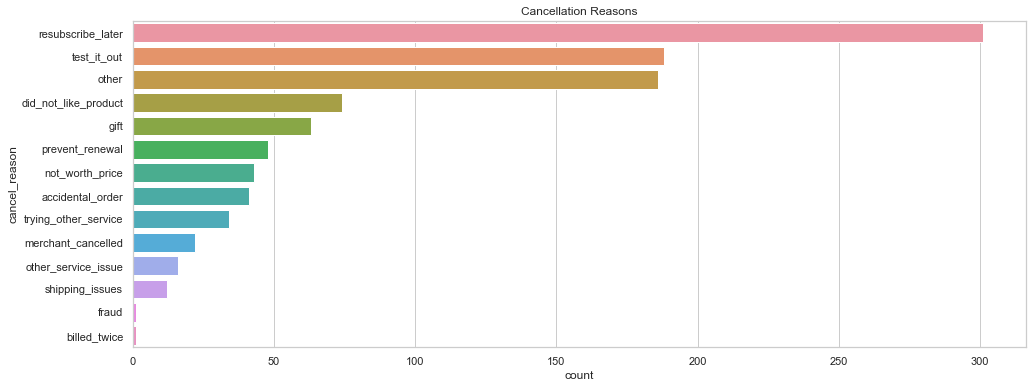

In [134]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
ax = sns.countplot(y="cancel_reason", data=cancellations, order = cancellations['cancel_reason'].value_counts().index)
ax.set_title("Cancellation Reasons")
plt.show()

In [135]:
#box content data
box = pd.read_csv(data_path + "Subscription/box.csv", encoding="utf8")
box = box.fillna(0)
box['Day'] = 15


In [136]:
box['num_books'] = box['num_hardcover'] + box['num_boardbook'] +  box['num_3d'] +  box['num_softcover'] +  box['num_chapter']
box['num_others'] = box['num_stickers'] + box['num_crafts'] +  box['num_stationary']
box['num_all'] = box['num_books'] + box['num_others']

box['Time']= pd.to_datetime(box[['Year','Month','Day']])
box = box.drop(columns=['Day'])

In [137]:
#Combine end date and cancel date into one column
subscriptions['end_date_all'] = subscriptions['End_Date_dt']
subscriptions.loc[subscriptions['Cancel_Date_dt']!='','end_date_all'] = subscriptions.loc[subscriptions['Cancel_Date_dt']!='','Cancel_Date_dt']
subscriptions = subscriptions.reset_index()

#This includes all but there're multicollinerity issues for regressions select wisely when training
new_cols = ['num_hardcover','num_boardbook','num_3d','num_softcover','num_chapter','num_stickers','num_crafts','num_stationary',
               'cost','num_books','num_others','num_all']

#new_cols_latest = [s + '_last' for s in new_cols]

for col in new_cols:
    subscriptions[col] = 0

#for col in new_cols_latest:
#    subscriptions[col] = 0
    

In [138]:
#Loop over each row and calculate the weighted average costs/number of items across all boxes
for index, row in subscriptions.iterrows():
    
    start_date = row['Start_Date_dt']
    end_date = row['end_date_all']
    age_group = row['Subscription_Product']

    box_received = box.loc[(box['Age']==age_group) & (box['Time']<=end_date) & (box['Time']>=start_date),
           'num_hardcover':'num_all']
    #avg_box = box_received.mean(axis=0)
    #subscriptions.loc[index, new_cols] = avg_box
    ewm_box = box_received.ewm(com=0.5).mean().iloc[-1:,].mean(axis=0)
    subscriptions.loc[index, new_cols] = ewm_box

    #last_box = box_received.iloc[-1:,].mean(axis=0)
    #last_box.index= new_cols_latest
    #subscriptions.loc[index, new_cols_latest] = last_box

In [139]:
#If NAs for the box info, it suggest their cancel date is not long after subscribe date
#And generally suggests they cancels before receiving the box
#Maybe they just don't want to auto-renewed 
#Replace with median

subscriptions[new_cols] = subscriptions[new_cols].fillna(subscriptions[new_cols].median()) 
#subscriptions[new_cols_latest] = subscriptions[new_cols_latest].fillna(subscriptions[new_cols_latest].median()) 

C:\Users\armcl\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1, 'Avg Box Attributes vs. Susbscription Status')

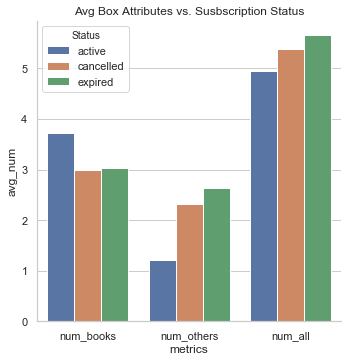

In [140]:
#Intersting, on average, if there're less books in the lifepsan of the client's subscription, they're more liketly to cancel
#However, more other stuff dosn't help

avg_box_by_status = subscriptions.groupby('Status').mean()[['num_books','num_others','num_all']].reset_index()
avg_box_by_status = pd.melt(avg_box_by_status, id_vars="Status", var_name="metrics", value_name="avg_num")

g = sns.factorplot(x='metrics', y='avg_num', hue='Status', data=avg_box_by_status, kind='bar', legend_out=False)
g.ax.set_title('Avg Box Attributes vs. Susbscription Status')


Text(0.5, 1, 'Avg Box Cost vs. Susbscription Status')

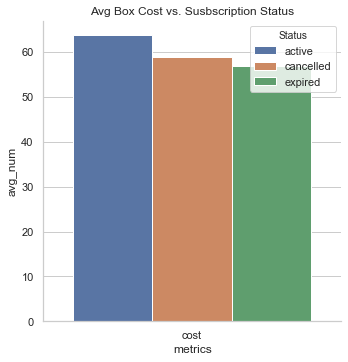

In [141]:
#Lower costs also might lead to cancellations but need to control for other variables to draw conclusions

cost_by_status = subscriptions.groupby('Status').mean()[['cost']].reset_index()
cost_by_status = pd.melt(cost_by_status, id_vars="Status", var_name="metrics", value_name="avg_num")

g=sns.factorplot(x='metrics', y='avg_num', hue='Status', data=cost_by_status, kind='bar', legend_out=False)
g.ax.set_title('Avg Box Cost vs. Susbscription Status')


In [142]:
#Feedback detail data
feedback_detail = pd.read_csv(data_path + "Subscription/feedback_detail.csv", encoding="utf8")

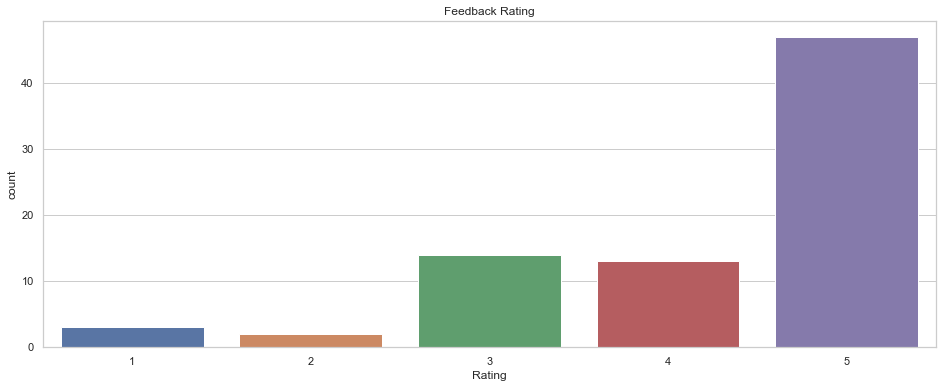

In [143]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))
ax = sns.countplot(x="Rating", data=feedback_detail)
ax.set_title("Feedback Rating")
plt.show()

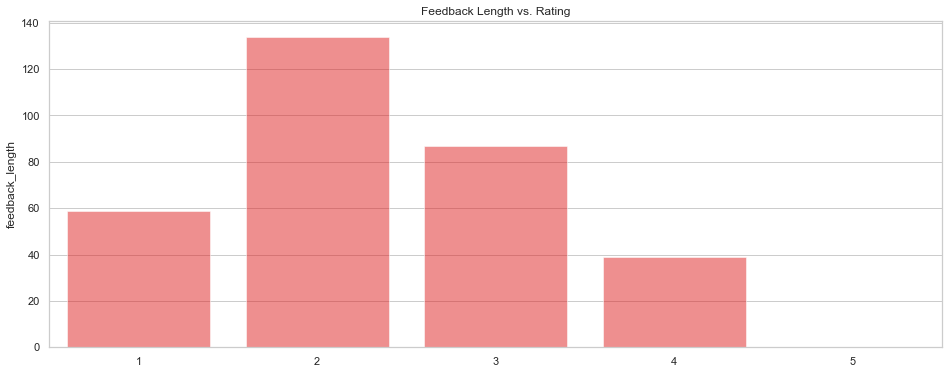

In [144]:
#Interstingly, the longest comments are with rating 2 and 3
#If it's awesome, they usually just leave a 5 star
#If it's really bad, they don't want to waste their time

feedback_detail['feedback_length'] = feedback_detail['Response'].str.len().fillna(0)
feedback_len_analysis = feedback_detail.groupby('Rating').median().reset_index()

plt.figure(figsize=(16, 6))
ax = sns.barplot(x="Rating", y="feedback_length", data=feedback_len_analysis, color='red',alpha=0.5,ci=None)

ax.set_title("Feedback Length vs. Rating")
ax.set_xlabel('')
plt.show()

In [145]:
#Average for customers who give more than 1 score before merging
feedback_detail = feedback_detail.groupby('Customer Email').mean().reset_index()

In [146]:
#Merge the rating and feedback length data to subscriptions
#Most clients actually didn't leave any rating/feedback
subscriptions = pd.merge(subscriptions, feedback_detail[['Customer Email','Rating','feedback_length']], left_on = 'Email', right_on='Customer Email', how='left')
subscriptions = subscriptions.drop(columns=['Customer Email'])

#Add a new feature if there's rating given
subscriptions['If_Any_Rating'] = 1
subscriptions.loc[subscriptions['Rating'].isnull(),'If_Any_Rating'] = 0

#Fill in NA with median
subscriptions['Rating'].fillna(feedback_detail['Rating'].median(), inplace = True) #this is 5
subscriptions['feedback_length'].fillna(feedback_detail['feedback_length'].median(), inplace = True)  #this is 0

#subscriptions.head()

In [147]:
#One-time Order Data
onetime_order = pd.read_csv(data_path + "Subscription/onetimeorder_legacy.csv", encoding="utf8")

In [148]:
#products is str type, convert it dummies of products
onetime_order = pd.concat([onetime_order, onetime_order['products'].str.get_dummies(sep=',')], axis=1)

#Create a new feature that counts the number of products bought
onetime_order['num_onetime'] = onetime_order.iloc[:,16:].sum(axis=1)

In [149]:
#Summing up for customers who have more than 1 orders before merging
onetime_order = onetime_order.groupby('email').sum().reset_index()

onetime_order.rename(columns={'total':'revenue_onetime'}, inplace = True)

onetime_order = onetime_order.drop(columns=['order_id','total_price','total_tax','total_shipping','is_gift'])
onetime_order['revenue_onetime'] = onetime_order['revenue_onetime']/100


In [150]:
#Merge to subscription data

subscriptions = pd.merge(subscriptions, onetime_order, left_on = 'Email', right_on='email', how='left')
subscriptions = subscriptions.drop(columns=['email'])

subscriptions.loc[:,'revenue_onetime':'num_onetime'] = subscriptions.loc[:,'revenue_onetime':'num_onetime'].fillna(0)
#subscriptions.head()

In [151]:
#Active subscribers buy more of the onetime items as well.
subscriptions.groupby('Status').mean()[['revenue_onetime','num_onetime']]

,revenue_onetime,num_onetime
Status,,
active,47.544175,1.718447
cancelled,16.233367,0.567114
expired,22.102353,0.588235


In [152]:
#Since the one time purchase data could happen after the cancellation, they can't be features
subscriptions = subscriptions.drop(subscriptions.loc[:, 'revenue_onetime':].columns, axis = 1) 

In [153]:
#Mail Campaign Data
mailchimp_subscribed = pd.read_csv(data_path + "Subscription/mailchimp_subscribed_members.csv", encoding="utf8")
mailchimp_subscribed['subscriber_type'] = 'mail_subscribed'

mailchimp_unsubscribed = pd.read_csv(data_path + "Subscription/mailchimp_unsubscribed_members.csv", encoding="utf8")
mailchimp_unsubscribed['subscriber_type'] = 'mail_unsubscribed'

mailchimp_cleaned = pd.read_csv(data_path + "Subscription/mailchimp_cleaned_members.csv", encoding="utf8")
mailchimp_cleaned['subscriber_type'] = 'mail_cleaned'

mailchimp = pd.concat([mailchimp_subscribed, mailchimp_unsubscribed, mailchimp_cleaned],ignore_index=True)
mailchimp = mailchimp[['Email Address','MEMBER_RATING','UNSUB_CAMPAIGN_TITLE','UNSUB_REASON',
          'UNSUB_TIME','CLEAN_TIME','subscriber_type']]

C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [154]:
mailchimp.groupby('UNSUB_REASON').size()

UNSUB_REASON
NORMAL      122
NOSIGNUP     27
OTHER         2
SPAM          4
dtype: int64

In [155]:
#Merge to subscription data

subscriptions = pd.merge(subscriptions, mailchimp[['Email Address','MEMBER_RATING','UNSUB_TIME','CLEAN_TIME','subscriber_type']], left_on = 'Email', right_on='Email Address', how='left')
subscriptions = pd.concat([subscriptions, subscriptions['subscriber_type'].str.get_dummies(sep=',')], axis=1)

#Only unsubscribe/clean before the actual box unsubscription is predictive
#Find the rows have both cancel_date_dt and UNSB_TIME not null
subscriptions['UNSUB_TIME']= pd.to_datetime(subscriptions['UNSUB_TIME']) 
unsub_after_unsub = subscriptions.loc[(subscriptions['UNSUB_TIME'].notnull())&(subscriptions['Cancel_Date_dt']!=''),:]
unsub_after_unsub.loc[unsub_after_unsub['UNSUB_TIME'] >= unsub_after_unsub['Cancel_Date_dt'],'unsub_to_remove'] = 1

#Merge to subscriptions and update the UNSUBSCRIBED column
subscriptions = pd.merge(subscriptions, unsub_after_unsub[['Email','unsub_to_remove']], left_on = 'Email', right_on='Email', how='left')
subscriptions.loc[subscriptions['unsub_to_remove']==1,'mail_unsubscribed'] = 0

subscriptions = subscriptions.drop(columns=['Email Address','unsub_to_remove'])

#Missing Member Rating fill with median
subscriptions['MEMBER_RATING'] = subscriptions['MEMBER_RATING'].fillna(subscriptions['MEMBER_RATING'].median())

#subscriptions.head()

C:\Users\armcl\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\armcl\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [156]:
#
subscriptions.groupby('Status').mean()[['MEMBER_RATING','mail_subscribed','mail_unsubscribed','mail_cleaned']]

,MEMBER_RATING,mail_subscribed,mail_unsubscribed,mail_cleaned
Status,,,,
active,3.540453,0.970874,0.019417,0.000000
cancelled,2.819058,0.794433,0.025696,0.028908
expired,2.411765,0.941176,0.000000,0.058824


In [157]:
#One-time Order Revenue Data
onetime_order_revenue = pd.read_csv(data_path + "Subscription/onetimeorder_revenue.csv", encoding="utf8")

onetime_order_revenue['Total Revenue'] = onetime_order_revenue['Total Revenue'].replace('[\$,]', '', regex=True).astype(float)

#onetime_order_revenue.head(2)

In [158]:
#coupon Data
coupons = pd.read_csv(data_path + "Subscription/coupon_revenue.csv", encoding="utf8")

coupons['num_used'] = coupons['Number of New Orders'] + coupons['Number of Renewal Orders']
coupons['Sum Total'] = coupons['Sum Total'].replace('[\$,]', '', regex=True).astype(float)
coupons['Total Discount'] = coupons['Total Discount'].replace('[\$,]', '', regex=True).astype(float)
coupons['Net_Income'] = coupons['Sum Total'] - coupons['Total Discount']

coupons['revenue_per_coupon'] = coupons['Sum Total']/coupons['num_used']
coupons['net_revenue_per_coupon'] = coupons['Net_Income']/coupons['num_used']

#coupons.head(2)

In [159]:
subscriptions.describe()

,index,Subscription ID,Total Revenue,Initial Order ID,Child_Age,canceled_tenure,active_tenure,subscribe_date,subscribe_hour,american,0-2 box,2-5 box,5+ box,12 Month Prepay,Month to Month,active,cancelled,expired,Not_Used_Coupon,Used_Coupon,Gift,Not_Gift,Boy,Girl,1STPANDA10OFF,DDDHHHZZZ,DIYA,ERXIGUO,GALA,GALTOGETHER10OFF,GALTOGETHER10OFF3M,GT1STFREE,GTFRESH,GTLOVE,GTLUCKY,GTMOM,GTNIAN,GTPANDA3M,GTSPRING,GTXMAS,GXFXXMHZ,HAPPY100DAYS,HEYWOW,HOTPANDA,KKMANDARIN,LIHANPANDA,LIHANSBOOKNEST,LINGOBUS,LOVECX,LUCKYMAMA,LUCKYMOM,LUCKYPANDA,LUCKYU,MDYANG,MESSYCOW,MESSYCOWVIP,MOLO,NIUMAVIP,PANDA09,PANDA10,PANDA127,PANDA1STFREE,PANDA54,PANDABUNNY,PANDACJ,PANDALOVE,PANDAMOM,PANDAMYDEAR,PANDAPICKUP,PANDAREUNION,PANDASHOP10,PANDASPRING,PANDAYAO,PANDAYEAR,RF2GET1FREE,RF3GET1FREE,RF6GET2NDFREE,SHIP50,SPONGELAB,USMAMA,USMAMA1Y,USMAMAVIP,USMAMAZJ,VIPFIRSTFREE,VIPFREEINF,VIPINFLUENCER,WEEE,WEEEVIP,XM,XMBABA,XMJSLH,XMPANDA,XMSEA,XMTTCD,XMVIP,XMXQ,XPANDA,XQDW,XQDWPD,YWZGG,ZYLYZXY,PAYPAL,STRIPE,Num_Coupons_Used,upgrade,life_span,num_hardcover,num_boardbook,num_3d,num_softcover,num_chapter,num_stickers,num_crafts,num_stationary,cost,num_books,num_others,num_all,Rating,feedback_length,If_Any_Rating,MEMBER_RATING,mail_cleaned,mail_subscribed,mail_unsubscribed
count,1260.000000,1.260000e+03,1260.000000,1.260000e+03,1260.000000,951.000000,309.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.0,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.0,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.0,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.0,1260.000000,1260.000000,1260.000000,1260.0,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.00000,1260.000000,1260.00000,1260.0,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000
mean,673.544444,2.050908e+09,110.856976,2.050907e+09,3.082587,78.654048,323.569579,14.607937,15.193651,0.051587,0.324603,0.539683,0.135714,0.198413,0.801587,0.245238,0.754762,0.0,0.228571,0.771429,0.009524,0.990476,0.498413,0.501587,0.011111,0.008730,0.0,0.009524,0.000794,0.001587,0.006349,0.008730,0.001587,0.002381,0.004762,0.002381,0.001587,0.000794,0.002381,0.015079,0.000794,0.000794,0.002381,0.109524,0.001587,0.001587,0.000794,0.005556,0.007143,0.007143,0.001587,0.161111,0.004762,0.000794,0.003175,0.0,0.003968,0.003175,0.081746,0.001587,0.011111,0.002381,0.000794,0.008730,0.010317,0.004762,0.001587,0.000794,0.008730,0.403175,0.000794,0.004762,0.003175,0.000794,0.000794,0.017460,0.000794,0.003175,0.000794,0.035714,0.003175,0.0,0.003175,0.017460,0.000794,0.0,0.001587,0.000794,0.000794,0.003175,0.001587,0.022222,0.000794,0.002381,0.026984,0.001587,0.014286,0.003175,0.003175,0.001587,0.002381,0.26746,0.639683,1.10873,0.0,138.716667,2.455900,0.128742,0.372892,0.193254,0.019018,0.614298,1.173187,0.219484,60.144440,3.173355,2.076811,5.285087,4.957143,25.946296,0.055556,2.990476,0.022222,0.839683,0.023810
std,391.821636,2.712126e+08,137.366705,2.712108e+08,1.915930,99.227348,167.173075,9.695209,5.647070,0.221280,0.468412,0.498621,0.342621,0.398963,0.398963,0.

In [160]:
subscriptions.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 0 to 1259
Data columns (total 151 columns):
index                         1260 non-null int64
Subscription ID               1260 non-null int64
First Name                    1260 non-null object
Last Name                     1255 non-null object
Email                         1260 non-null object
Status                        1260 non-null object
Total Revenue                 1260 non-null float64
Fulfillment Status            1260 non-null object
Auto-Renewing Subscription    1260 non-null bool
Is a Gift                     1260 non-null object
Shipping City                 1260 non-null object
Shipping Zip                  1260 non-null object
Shipping Province             1260 non-null object
Shipping Country              1260 non-null object
Initial Order ID              1260 non-null int64
Term                          1260 non-null object
Subscription_Product          1260 non-null object
Child_Age                    

In [161]:
subscriptions['Cancel_Date'] = pd.to_datetime(subscriptions['Cancel_Date_dt']).dt.strftime('%Y/%m')
cancel_subscriptions = subscriptions[subscriptions['cancelled'] == 1]

In [162]:
cancel_subscriptions = cancel_subscriptions.sort_values(by=['Cancel_Date'])
cancel_subscriptions_num = cancel_subscriptions.groupby('Cancel_Date').count()

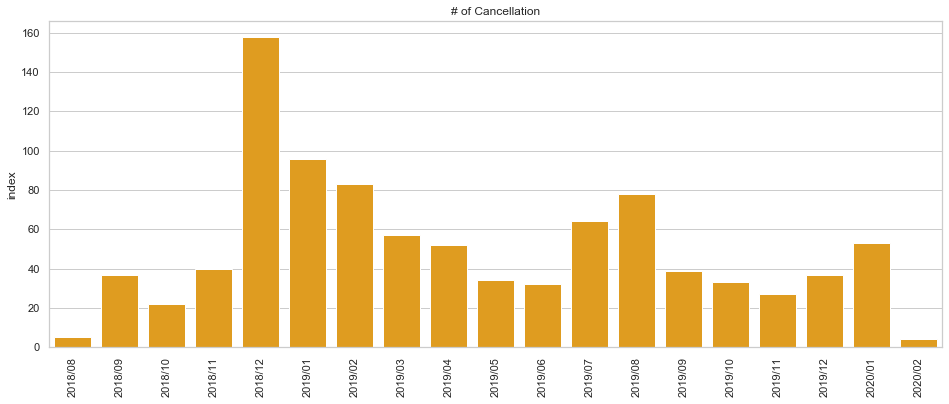

In [163]:
#subscriptions
cancel_subscriptions = cancel_subscriptions.sort_values(by=['Cancel_Date'])
cancel_subscriptions_num = cancel_subscriptions.groupby('Cancel_Date').count()

plt.figure(figsize=(16, 6))
ax = sns.barplot(x=cancel_subscriptions_num.index, y="index", color="orange", data=cancel_subscriptions_num)
plt.xticks(plt.xticks()[0], cancel_subscriptions_num.index, rotation=90)
ax.set_xlabel('')
ax.set_title("# of Cancellation")
#plt.tight_layout()
plt.show()

In [164]:
#Remove active users who have life spans less than 100 days
#Give them some time to experience the product and decide
subscriptions = subscriptions.loc[~((subscriptions['Status'] == 'active') & (subscriptions['life_span'] <= 60)),:]

#Remove the observations who subscribed by getting the box for free and canceled right after

subscriptions = subscriptions.loc[~((subscriptions['HOTPANDA'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['GTXMAS'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['DIYA'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['GT1STFREE'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['GTLUCKY'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['GTLOVE'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['KKMANDARIN'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['LINGOBUS'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['LUCKYMAMA'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['LUCKYMOM'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['LUCKYPANDA'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['LUCKYU'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['PANDA1STFREE'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['USMAMAZJ'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['VIPFIRSTFREE'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['VIPFREEINF'] == 1) & (subscriptions['life_span'] <= 60)),:]
subscriptions = subscriptions.loc[~((subscriptions['VIPINFLUENCER'] == 1) & (subscriptions['life_span'] <= 60)),:]


In [165]:
#State might be useful but not enough data
#subscriptions = pd.concat([subscriptions, subscriptions['Shipping Province'].str.get_dummies(sep=',')], axis=1)

#Dropping nonrelated columns

subscriptions = subscriptions.drop(columns=['index','active','Subscription ID','First Name',
'Last Name','Email','Status','Fulfillment Status','Auto-Renewing Subscription',
'Is a Gift','Shipping City','Shipping Zip','Shipping Country','Initial Order ID',
'Term','Subscription_Product','Child_Gender','Coupon_Used','Start_Date_dt','End_Date_dt',
'Cancel_Date_dt','Start_Date_Long','Cancel_Date_Long','canceled_tenure','active_tenure',
'subscribe_date','subscribe_hour','cancel_date','cancel_hour','expired','upgrade',
'end_date_all','UNSUB_TIME','CLEAN_TIME','subscriber_type','mail_subscribed',
'Shipping Province','num_all','5+ box','Month to Month','Not_Used_Coupon','Not_Gift',
'Girl','STRIPE','Cancel_Date','HOTPANDA','GTXMAS','DIYA','GT1STFREE','GTLUCKY',
'KKMANDARIN','LINGOBUS','LUCKYMAMA','LUCKYMOM','LUCKYPANDA','LUCKYU','MDYANG',
'PANDA1STFREE','USMAMAZJ','VIPFIRSTFREE','VIPFREEINF','VIPINFLUENCER','GTLOVE','XMBABA',
'XMSEA','XQDW','feedback_length'])

#using life span is cheating, life span is determined by subscription status
subscriptions = subscriptions.drop(columns=['life_span'])

subscriptions = subscriptions.rename(columns={"Total Revenue":"Tot_Sub_Revenue",
"0-2 box":"0-2_box","2-5 box":"2-5_box",
"12 Month Prepay":"12m_prepay"})

In [166]:
#Start with a basic logistic regression
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
from sklearn.model_selection import train_test_split

#Since some of the box features are aggregated from component features, drop either one of them
box_agg_features = ['num_books','num_others']
box_component_features = ['num_hardcover','num_boardbook','num_3d','num_softcover',
                         'num_chapter','num_stickers','num_crafts','num_stationary']

subscriptions_logit1 = subscriptions.drop(columns=box_component_features)

target = ['cancelled'] 
features = list(subscriptions_logit1.drop(['cancelled','Tot_Sub_Revenue'],axis=1).columns)
subscriptions_logit1[features] = scaler.fit_transform(subscriptions_logit1[features])


X = subscriptions_logit1[features]
y = subscriptions_logit1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

(649, 74)
(279, 74)


In [167]:
#RFE Feature Selection
#Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model 
#and choose either the best or worst performing feature, setting the feature aside and then
#repeating the process with the rest of the features.

from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.feature_selection import RFE

logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train)

print ("Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), features)))

C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features sorted by their rank:
[(1, '0-2_box'), (1, '12m_prepay'), (1, '2-5_box'), (1, 'Child_Age'), (1, 'GTMOM'), (1, 'Gift'), (1, 'MEMBER_RATING'), (1, 'NIUMAVIP'), (1, 'PANDA09'), (1, 'PANDA127'), (1, 'PANDAREUNION'), (1, 'PANDAYEAR'), (1, 'SHIP50'), (1, 'SPONGELAB'), (1, 'USMAMA1Y'), (1, 'XPANDA'), (1, 'ZYLYZXY'), (1, 'mail_cleaned'), (1, 'num_books'), (1, 'num_others'), (2, 'DDDHHHZZZ'), (3, 'XMTTCD'), (4, 'XQDWPD'), (5, 'PANDALOVE'), (6, 'PANDA10'), (7, 'PANDASHOP10'), (8, 'HAPPY100DAYS'), (9, 'PANDAMOM'), (10, 'GTSPRING'), (11, 'RF2GET1FREE'), (12, 'PANDAYAO'), (13, 'XMXQ'), (14, 'PANDABUNNY'), (15, 'Used_Coupon'), (16, 'XMVIP'), (17, 'ERXIGUO'), (18, 'MESSYCOW'), (19, 'XMPANDA'), (20, 'PANDASPRING'), (21, 'GTNIAN'), (22, '1STPANDA10OFF'), (23, 'Rating'), (24, 'american'), (25, 'Boy'), (26, 'PANDACJ'), (27, 'RF6GET2NDFREE'), (28, 'GALA'), (29, 'WEEE'), (30, 'PANDAPICKUP'), (31, 'cost'), (32, 'USMAMA'), (33, 'HEYWOW'), (34, 'GTFRESH'), (35, 'PANDA54'), (36, 'If_Any_Rating'), (37,

In [168]:
#Top 20 features selected from RFE

features_sorted_by_rank = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), features))
selected_features = [x[1] for x in features_sorted_by_rank[:20]]
selected_features

['0-2_box',
 '12m_prepay',
 '2-5_box',
 'Child_Age',
 'GTMOM',
 'Gift',
 'MEMBER_RATING',
 'NIUMAVIP',
 'PANDA09',
 'PANDA127',
 'PANDAREUNION',
 'PANDAYEAR',
 'SHIP50',
 'SPONGELAB',
 'USMAMA1Y',
 'XPANDA',
 'ZYLYZXY',
 'mail_cleaned',
 'num_books',
 'num_others']

In [169]:
selected_features = ['0-2_box',
 '12m_prepay',
 '2-5_box',
 'Child_Age',
 'Gift',
 'MEMBER_RATING',
 'PANDAREUNION',
 'XPANDA',
 'mail_cleaned',
 'num_books',
 'num_others']

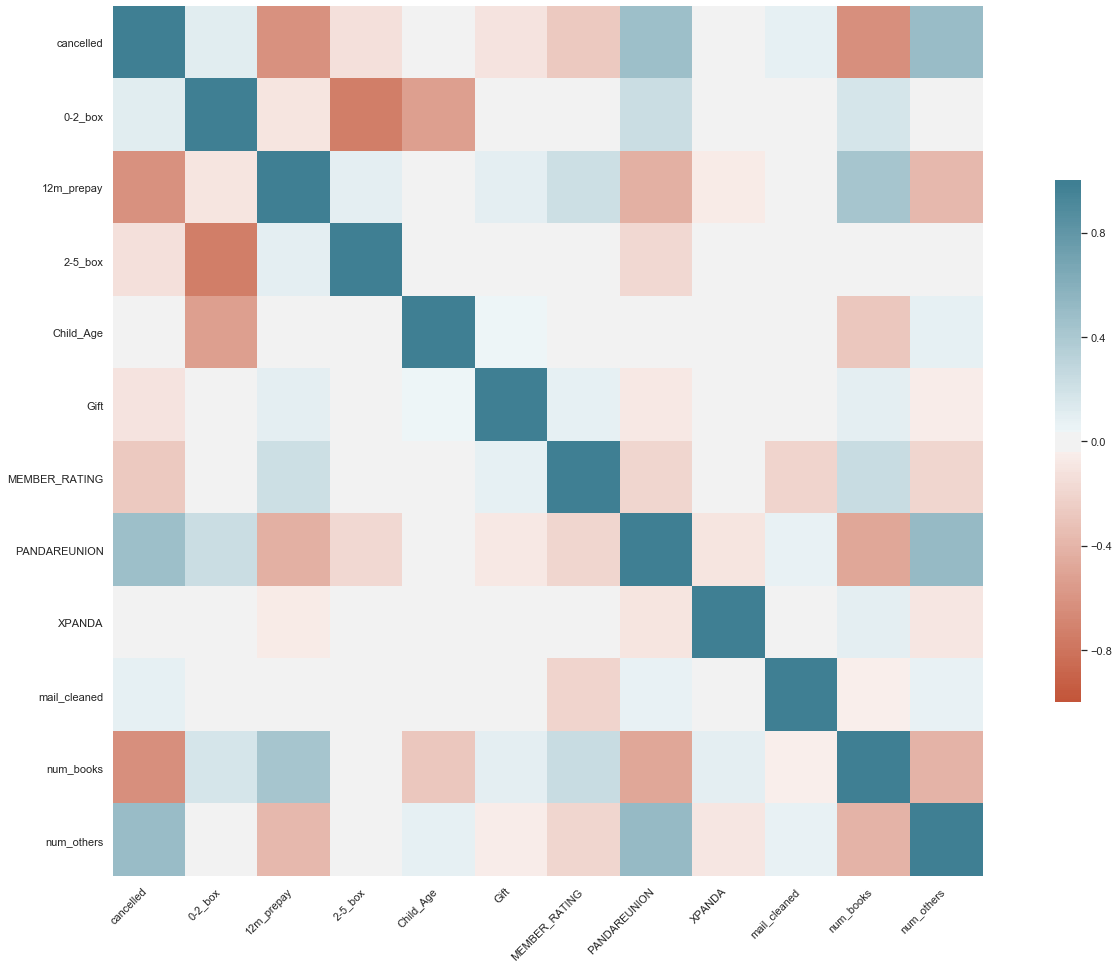

In [170]:
#Make a correlation heatmap

validation = subscriptions_logit1[target+selected_features]

plt.figure(figsize=(26, 16))

corr = validation.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, cbar=True,cbar_kws={"shrink": .6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [171]:
#Use the selected features and run the model

X = subscriptions_logit1[selected_features]
y = subscriptions_logit1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

#Use p-value to find the significance of variables
import statsmodels.api as sm
logit_model=sm.Logit(y,X)

result=logit_model.fit()

print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.326100
         Iterations 8
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.486      
Dependent Variable: cancelled        AIC:              627.2423   
Date:               2020-04-02 15:11 BIC:              680.4057   
No. Observations:   928              Log-Likelihood:   -302.62    
Df Model:           10               LL-Null:          -588.35    
Df Residuals:       917              LLR p-value:      2.2922e-116
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
0-2_box         0.8926    0.2622   3.4048  0.0007   0.3788   1.4064
12m_prepay     -1.1142    0.1354  -8.2302  0.0000

C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [172]:
#Remove the features with high P values

selected_features = ['0-2_box','12m_prepay','XPANDA',
                     'num_books','num_others']

X = subscriptions_logit1[selected_features]
y = subscriptions_logit1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

#Use p-value to find the significance of variables
import statsmodels.api as sm
logit_model=sm.Logit(y,X)

result=logit_model.fit()

print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.332125
         Iterations 8
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.476      
Dependent Variable: cancelled        AIC:              626.4236   
Date:               2020-04-02 15:11 BIC:              650.5887   
No. Observations:   928              Log-Likelihood:   -308.21    
Df Model:           4                LL-Null:          -588.35    
Df Residuals:       923              LLR p-value:      6.1298e-120
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
0-2_box        0.9465    0.1538    6.1559  0.0000   0.6451   1.2478
12m_prepay    -1.0947    0.1298   -8.4351  0.0000

C:\Users\armcl\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [173]:
print("Intercept is:",logreg.intercept_)

for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, logreg.coef_[0][idx]))

Intercept is: [2.77963567]
The coefficient for 0-2_box is 2.2263676889187454
The coefficient for 12m_prepay is -0.7715488302393211
The coefficient for XPANDA is 0.38193396870667207
The coefficient for num_books is -2.7832406037087445
The coefficient for num_others is 1.8711010244600221


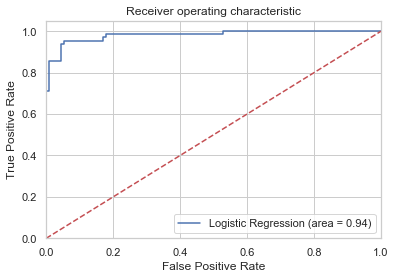

In [174]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1]) #predicted probability of cancellation
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [175]:
#Using the default 0.5 as the threshold for classification

print('Accuracy score = ',metrics.accuracy_score(y_test, y_pred))
print('Precision = ',metrics.precision_score(y_test, y_pred))
print('Recall = ',metrics.recall_score(y_test, y_pred))
print('F1 score = ',metrics.f1_score(y_test, y_pred))

Accuracy score =  0.942652329749104
Precision =  0.9520958083832335
Recall =  0.9520958083832335
F1 score =  0.9520958083832335


Confusion matrix, without normalization
[[104   8]
 [  8 159]]
Normalized confusion matrix
[[0.92857143 0.07142857]
 [0.04790419 0.95209581]]


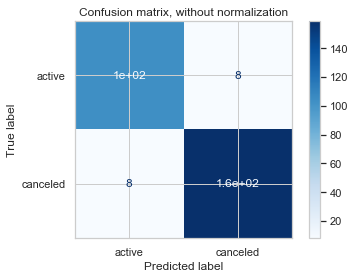

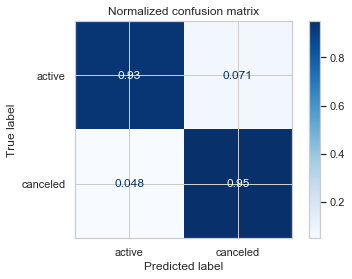

In [176]:
#False Postivie (false alarm) Rate  

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(logreg, X_test, y_test,
                                 display_labels=['active','canceled'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [177]:
#Try a random forest model


from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=100, random_state = 42, 
                                max_depth = 3) #number of trees in the forest

X = subscriptions[features]
#X = subscriptions[essential_features]
y = subscriptions[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

feature_imp = pd.Series(rf.feature_importances_,index=features).sort_values(ascending=False)
feature_imp[0:20]

(649, 74)
(279, 74)


C:\Users\armcl\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


num_books           0.186917
num_others          0.181606
12m_prepay          0.177422
cost                0.111719
PANDAREUNION        0.091060
Used_Coupon         0.048609
Num_Coupons_Used    0.038159
MEMBER_RATING       0.037917
XMVIP               0.018779
Child_Age           0.015371
Gift                0.012562
PANDA09             0.011031
XMPANDA             0.009743
0-2_box             0.007421
PANDA127            0.007313
2-5_box             0.006207
USMAMA1Y            0.005942
If_Any_Rating       0.004681
PANDAYAO            0.003079
XMXQ                0.002894
dtype: float64

No handles with labels found to put in legend.


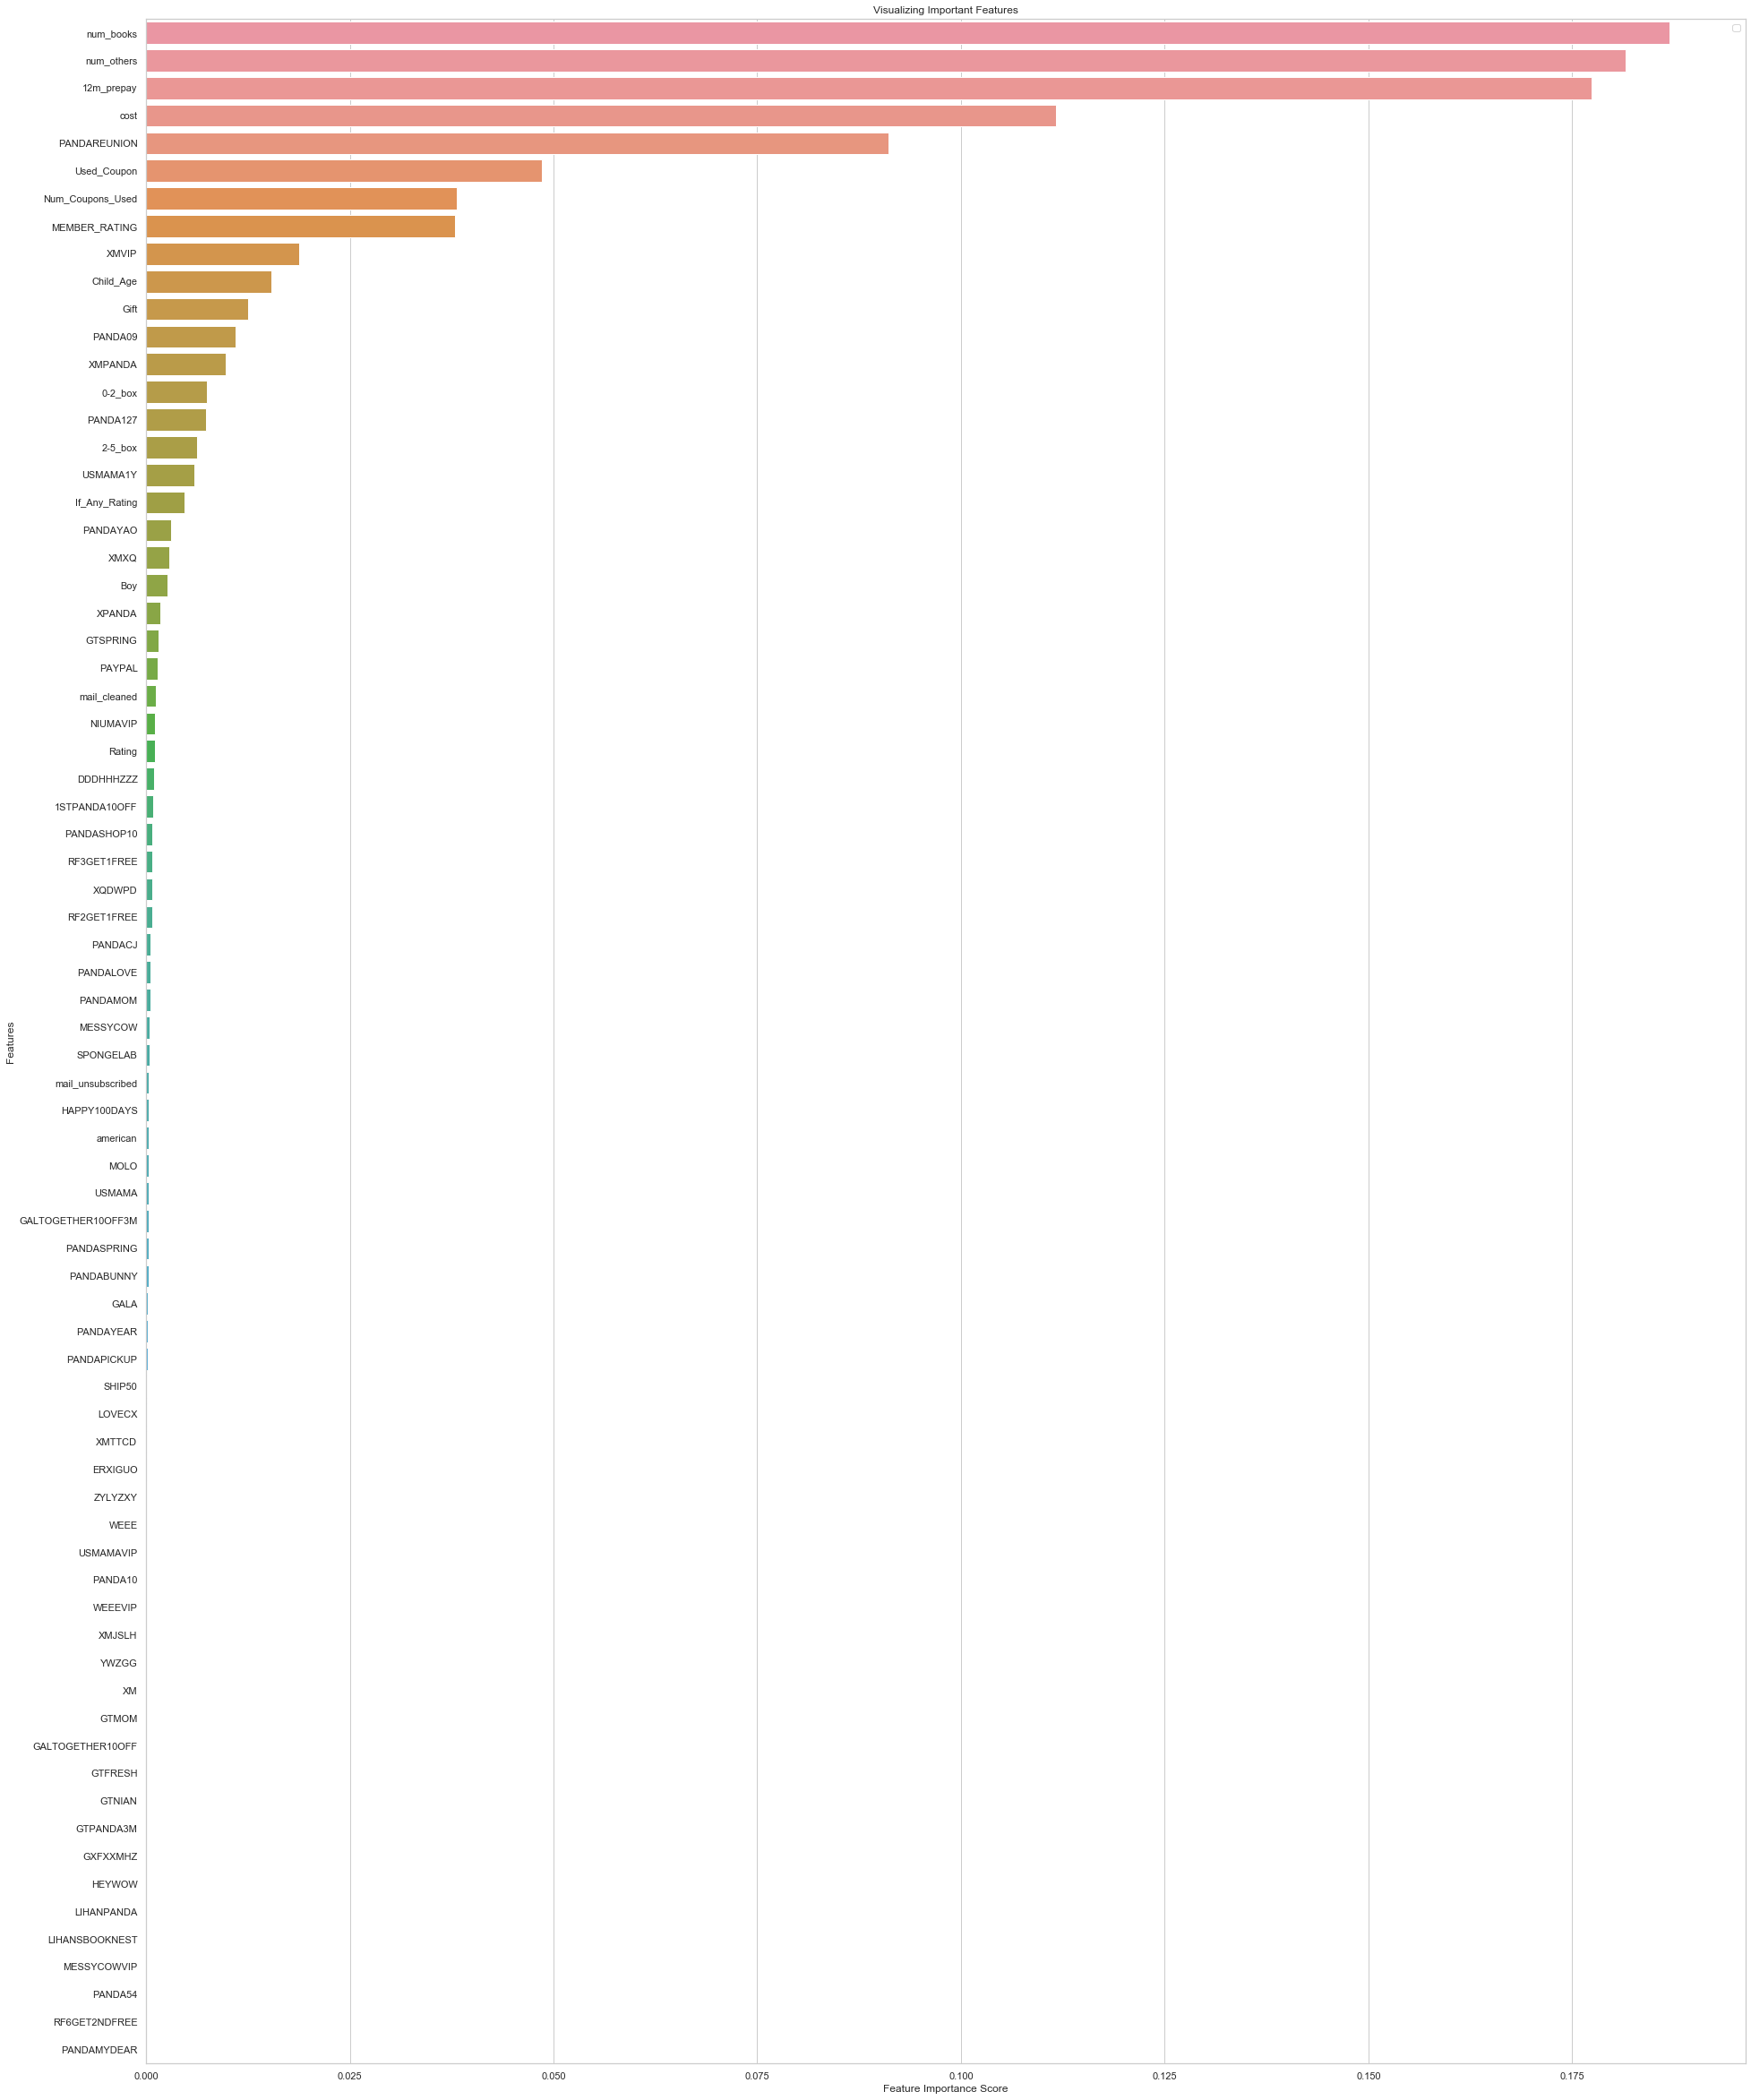

In [178]:

plt.figure(figsize=(32, 42))
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

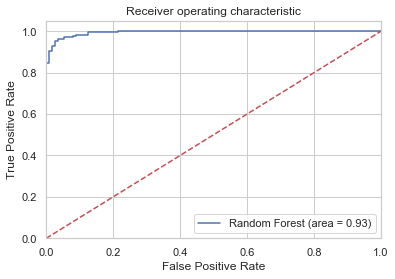

In [179]:
logit_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1]) #predicted probability of cancellation
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [180]:
print('Accuracy score = ',metrics.accuracy_score(y_test, y_pred))
print('Precision = ',metrics.precision_score(y_test, y_pred))
print('Recall = ',metrics.recall_score(y_test, y_pred))
print('F1 score = ',metrics.f1_score(y_test, y_pred))

Accuracy score =  0.942652329749104
Precision =  0.9265536723163842
Recall =  0.9820359281437125
F1 score =  0.9534883720930232


Confusion matrix, without normalization
[[ 99  13]
 [  3 164]]
Normalized confusion matrix
[[0.88392857 0.11607143]
 [0.01796407 0.98203593]]


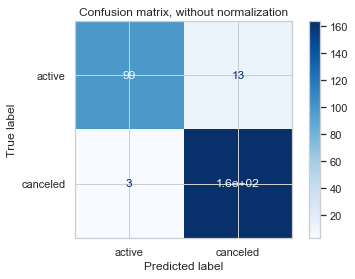

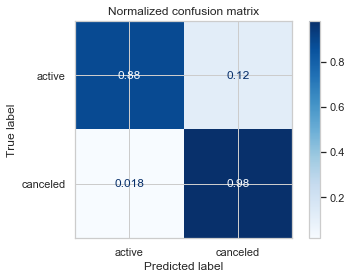

In [181]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, X_test, y_test,
                                 display_labels=['active','canceled'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()